In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()

        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim = embed_dim)
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation = "relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask=None):
        attn_output = self.att(inputs, inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training= training)
        ffn_output = self.layernorm2(ffn_output + out1)   

        return ffn_output

#### Data Preparation

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# load data
data = pd.read_csv("stock_prices.csv")
data = data[["close"]].values

In [3]:
# Normaliza data
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

# prepare for training
def create_dataset(data, time_step =1):
    x, y = [],[]
    for i in range(len(data) - time_step -1):
        a = data[i:(i + time_step), 0] # Slice a sequence from data
        x.append(a)
        y.append(data[i + time_step, 0]) # append the next value to y
    return np.array(x), np.array(y)

time_step = 60
x, y = create_dataset(data, time_step)

In [4]:
# Print the output

print("Length of data : " , len(data))
print("Length of x : " , len(x))
print("shape of first element in x: ", x[0].shape if len(x) > 0 else "x is empty")
print("Shape of y : ", y.shape)

#reshape x to fit LSTM input shape requirements (if x is not empty)
if len(x) > 0:
    x = x.reshape(x.shape[0], x.shape[1], 1)
    print("Shape of x after reshape:" , x.shape)
    print("shape of x : ", x.shape)
    print("shape of y : ", y.shape)

Length of data :  2000
Length of x :  1939
shape of first element in x:  (60,)
Shape of y :  (1939,)
Shape of x after reshape: (1939, 60, 1)
shape of x :  (1939, 60, 1)
shape of y :  (1939,)


#### Transformer model

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding

# Define transformer model
input_shape = (x.shape[1], 1)
inputs = Input(shape=input_shape)

# Embeddign layer
t = Dense(128)(inputs)

# Transformer block
for _ in range(4):
    t = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=512)(t, training=True)

# Output layer
t = Flatten()(t)
outputs = Dense(1)(t)

# Create the model
model = Model(inputs, outputs)

# Compile model
model.compile(optimizer = "adam",
              loss = "mse",
              metrics = ["accuracy"]
             )

# train thte model
model.fit(x, y, epochs = 20, batch_size=32)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.0000e+00 - loss: 15.1918
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.0000e+00 - loss: 0.2189
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.0000e+00 - loss: 0.1851
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.0000e+00 - loss: 0.1559
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 8.8122e-05 - loss: 0.1389
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 4.2270e-05 - loss: 0.0959
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 8.1132e-04 - loss: 0.0886
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 4.7224e-04 - loss: 0.1062
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 8.9915e-04 - loss: 0.0816
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 2.9973e-04 - loss: 0.0708
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 2.5771e-04 - loss: 0.0814
Epoc

#### Evaluating model and make predictions


Epoch 1/10


C:\ProgramData\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0553
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.1993e-04
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.1101e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8325e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.0580e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.6978e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.6305e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.9285e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.8277e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.0823e-04
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step  


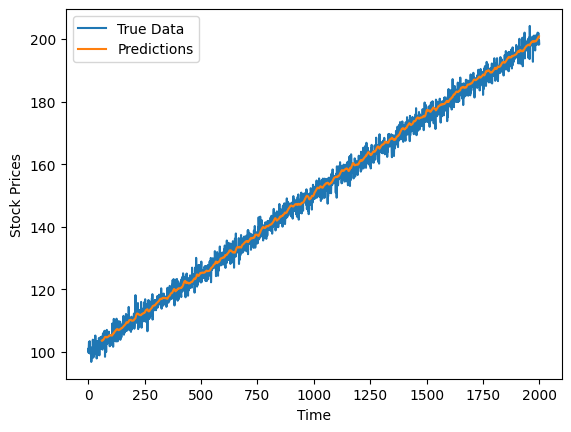

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam",
              loss = "mse"
             )

model.fit(x, y, epochs = 10, batch_size=32)

predictions = model.predict(x)

# Inverse transform the predictions to get the original scale
predictions = scaler.inverse_transform(predictions)

# Plot the predictions
plt.plot(scaler.inverse_transform(data), label="True Data")
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label="Predictions")
plt.xlabel("Time")
plt.ylabel("Stock Prices")
plt.legend()
plt.show()